# What is a Kuzushiji-MNIST?

Hello everyone! Today, we are here with another very cool dataset **KMNIST**, short for **Kuzushiji-MNIST**.  This dataset was showcased at NeurIPS 2018 along with a [paper](https://arxiv.org/pdf/1812.01718.pdf).  The dataset is actually divided into three categories:<br>
* **Kuzushiji-MNIST** is a drop-in replacement for the MNIST dataset (28x28 grayscale, 70,000 images), provided in the original MNIST format as well as a NumPy format. Since MNIST restricts us to 10 classes, we chose one character to represent each of the 10 rows of Hiragana when creating Kuzushiji-MNIST.

* **Kuzushiji-49**, as the name suggests, has 49 classes (28x28 grayscale, 270,912 images), is a much larger, but imbalanced dataset containing 48 Hiragana characters and one Hiragana iteration mark.

* **Kuzushiji-Kanji** is an imbalanced dataset of total 3832 Kanji characters (64x64 grayscale, 140,426 images), ranging from 1,766 examples to only a single example per class.

In this kernel, we will focus on the **Kuzushiji-MNIST**  dataset. For many years, researchers have been using MNIST as one of the standard datasets for benchmarking their algorithms. No doubt that MNIST is a very good dataset but given the advancements that we have achieved in deep learning in the last 5 years, it is high time to replace MNIST with a more challenging dataset.  The above point is fair but why KMNIST? What makes it unique? Why is it important?

Actually,  cursive Kuzushiji (くずし字) was an integral part of Japanese culture in the pre-modernisation era. It has been used for more than 1000 years but with the reforms done by Japanese leaders in the Japanese education system in 1868 and the following years, Kuzushiji was no longer seen as an important part and as a result, it is no longer taught in the official school curriculum.  Now you may ask: "So what? Japanese lost the script but with modernisation, such things are expected. Why do you think it is important at all?"

Fair question! As a result of the changes that were made in the education system, most Japanese cannot read books over 150 years old, written in cursive Kuzushiji style. Also, According to the General Catalog of National Books, there have been over 1.7 million books written or published in Japan prior to 1867 along with a billion of unregistered books. **Almost every book, no matter what, always provides some sort of knowledge**.  So, in short, we have a lot of knowledge lying around in those books but we don't have many people who are experts in reading and extracting information from them. Because of lack of domain experts, the process of digitizing that knowledge is slow. 

This dataset can help non-experts to develop systems that can be implemented to extract the information from those millions and billions of books. Deep learning can certainly be very useful in this task. If you want more info about the topic, I suggest reading that paper I mentioned above. Let's dive into the dataset now and see how different is it from MNIST.  
 


![SophiaImitation](tarry2.png)

# Visializing Stuff#


In [ ]:
import numpy as np
import pandas as pd
import mlcrate as mlc
from skimage.io import imread, imsave
from skimage.transform import resize

In [ ]:
# Download and display our image
# from urllib import request
# from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
# url = 'https://tarrysingh.com/wp-content/uploads/2008/12/AAEAAQAAAAAAAAdTAAAAJDdjMzE0NjQyLWQ1MDQtNGEyOC05NzgwLTFlNjVkNWM1YTE4MQ.jpg'
# data = BytesIO(request.urlopen(url).read())
image = imread('input/tarry2.jpg', format='jpg')

plt.imshow(image)
img = image[:, :, 0]
plt.imshow(img, cmap='gray')

In [ ]:
# Load Kuzushiji-49 and bin characters by mean grey level
imgs_train = np.load('input/k49-train-imgs.npz')['arr_0']
means = (255 - imgs_train).mean(axis=1).mean(axis=1)
plt.hist(means, bins=50, log=True)

from collections import defaultdict
character_bins = defaultdict(list)
for char, mean in zip(imgs_train, means):
    character_bins[int(mean)].append(char)

In [ ]:
# Note this is multiplied by 28x28 since each pixel is replaced by a character
OUTPUT_RESOLUTION = (96, 75) 
# Rescale pixels to (120, 245) since K49 doesn't have characters with lower gray levels

img_small = (resize(img, OUTPUT_RESOLUTION, preserve_range=True) / 2) + 120 
plt.hist(img_small.flatten(), bins=50, log=True)
plt.show()
plt.imshow(img_small, cmap='gray')
None

In [ ]:
new_img = np.zeros((img_small.shape[0]*28, img_small.shape[1]*28), dtype=np.uint8)

In [ ]:
# Loop over all pixels in original image, selecting a random character from K49 with same gray level, 
# and putting that character in the same position in the new image
ix = 0
iy = 0
for iy in range(img_small.shape[0]):
    for ix in range(img_small.shape[1]):
        level = int(img_small[iy, ix])
        charbin = character_bins[level]
        if len(charbin) == 0:
            charbin = character_bins[level + 1]
        if len(charbin) == 0:
            charbin = character_bins[level - 1]
        char = 255 - charbin[np.random.choice(np.arange(len(charbin)))]
        new_img[iy*28:(iy+1)*28, ix*28:(ix+1)*28] = char

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(new_img, cmap='gray')

## Part 2 : Actually playing with the KMNIST Dataset 

### Install stuff you may need

```shekk
!pip install imgaug

!pip install -U seaborn

!pip uninstall umap -y

!pip install umap-learn
```

In [2]:
# -*- coding: utf-8 -*-

# I don't like warnings, especially user warnings at all!
import warnings
warnings.filterwarnings('ignore')

###  Import all these guys :-)

In [24]:
# Import some packages that we require
import os
import glob
import umap
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Sequential, Model
from keras.applications import vgg16
from keras.applications import resnet50
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
# from keras.optimizers import Adam, RMSprop
from keras import optimizers
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from skimage.io import imread, imshow
from skimage.transform import resize
import imgaug as ia
from imgaug import augmenters as iaa
from keras import backend as K
import tensorflow as tf
from collections import defaultdict, Counter
print(os.listdir("input"))

['kmnist-test-imgs.npz', 'kkanji.tar', 't10k-images-idx3-ubyte.gz', 'kmnist-train-labels.npz', 'k49-test-imgs.npz', 't10k-labels-idx1-ubyte.gz', 'kmnist-train-imgs.npz', 'k49-test-labels.npz', 'k49-train-imgs.npz', 'tarry.png', 'k49_classmap.csv', 'kernel-3.ipynb', 'train-labels-idx1-ubyte.gz', 'tarry.jpg', 'tarry2.jpg', 'kmnist-test-labels.npz', 'train-images-idx3-ubyte.gz', '.ipynb_checkpoints', 'k49-train-labels.npz', 'kmnist_classmap.csv']


In [4]:
# For plotting within the notebook
%matplotlib inline

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

# seaborn color palette 
color = sns.color_palette()

# For REPRODUCIBILITY
seed = 111
np.random.seed(seed)
tf.set_random_seed(seed)

In [5]:
# Let us define some paths first
input_path = Path("input")

# Path to training images and corresponding labels provided as numpy arrays
kmnist_train_images_path = input_path/"kmnist-train-imgs.npz"
kmnist_train_labels_path = input_path/"kmnist-train-labels.npz"

# Path to the test images and corresponding labels
kmnist_test_images_path = input_path/"kmnist-test-imgs.npz"
kmnist_test_labels_path = input_path/"kmnist-test-labels.npz"

### Load the dataset<br>
The focus of this kernel is going to be kmnisr, drop-in replacement for MNIST. So, we will be loading only that dataset. Also, KMNIST is provided in two formats: 
* Raw images and labels
* Images and labels as numpy arrays stored in `npz` file format

We will be using the `npz` files to load and process the data because it is much faster as well as the recommended way.

In [6]:
# Load the training data from the corresponding npz files
kmnist_train_images = np.load(kmnist_train_images_path)['arr_0']
kmnist_train_labels = np.load(kmnist_train_labels_path)['arr_0']

# Load the test data from the corresponding npz files
kmnist_test_images = np.load(kmnist_test_images_path)['arr_0']
kmnist_test_labels = np.load(kmnist_test_labels_path)['arr_0']

print(f"Number of training samples: {len(kmnist_train_images)} where each sample is of size: {kmnist_train_images.shape[1:]}")
print(f"Number of test samples: {len(kmnist_test_images)} where each sample is of size: {kmnist_test_images.shape[1:]}")

Number of training samples: 60000 where each sample is of size: (28, 28)
Number of test samples: 10000 where each sample is of size: (28, 28)


### Labels and their distribution<br>
As the dataset is a drop-in replacement for MNIST, it is expected that it will have 10 labels but for the sanity check, let's look into it and check how many samples for each label are there in  the training data 

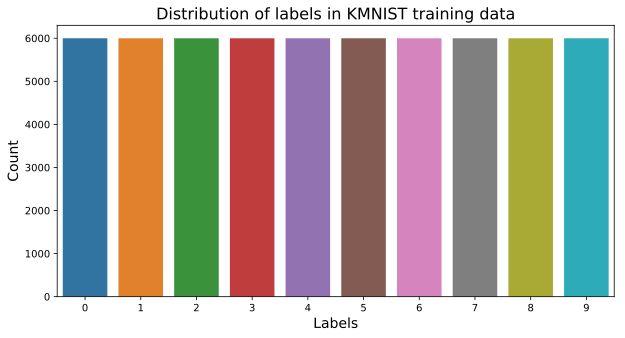

In [7]:
# Get the unique labels
labels = np.unique(kmnist_train_labels)

# Get the frequency count for each label
frequency_count = np.bincount(kmnist_train_labels)

# Visualize 
plt.figure(figsize=(10,5))
sns.barplot(x=labels, y=frequency_count);
plt.title("Distribution of labels in KMNIST training data", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

### Quick sneak peek
Before moving further, we will get some random samples for each label in the training data. We will look at how the images for each character(label) looks like and how much is the variation between samples of the same class. Given these samples without any prior, would you be able to group them correctly?   😛 

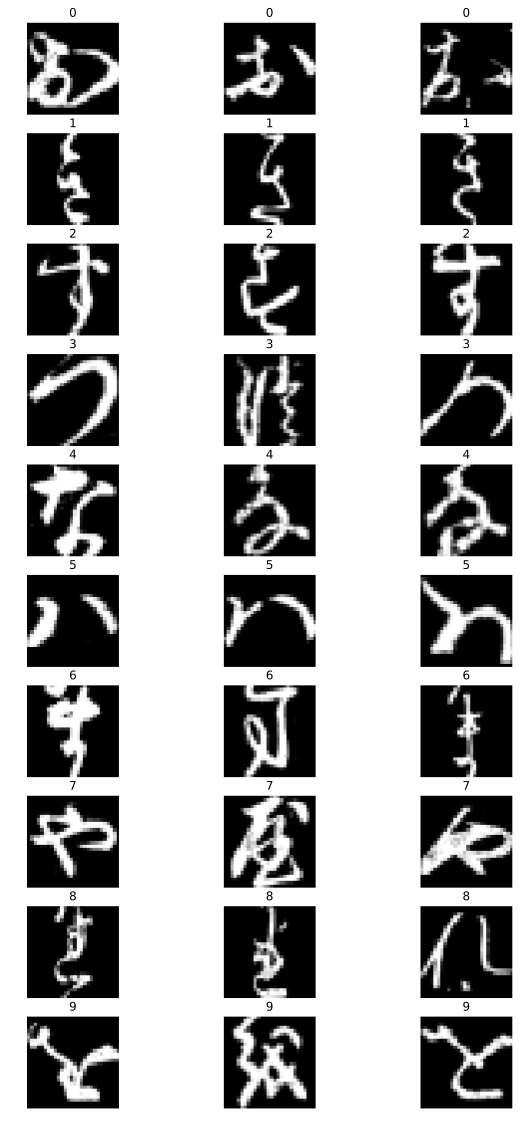

In [8]:
# Let's see how the images for different labels look like
random_samples = []
for i in range(10):
    samples = kmnist_train_images[np.where(kmnist_train_labels==i)][:3]
    random_samples.append(samples)

# Converting list into a numpy array
random_samples = np.array(random_samples)

# Visualize the samples
f, ax = plt.subplots(10,3, figsize=(10,20))
for i, j in enumerate(random_samples):
    ax[i, 0].imshow(random_samples[i][0,:,:], cmap='gray')
    ax[i, 1].imshow(random_samples[i][1,:,:], cmap='gray')
    ax[i, 2].imshow(random_samples[i][2,:,:], cmap='gray')
    
    ax[i,0].set_title(str(i))
    ax[i,0].axis('off')
    ax[i,0].set_aspect('equal')
    
    ax[i,1].set_title(str(i))
    ax[i,1].axis('off')
    ax[i,1].set_aspect('equal')
    
    ax[i,2].set_title(str(i))
    ax[i,2].axis('off')
    ax[i,2].set_aspect('equal')
plt.show()

### t-SNE and UMAP
Visulaizing high-dimensional data is always fun. Plus it can give you some basic insights about local and global relationships within the data, though it totally depends on your problem statement. Currently, there are two widely used algoritms that are used for visualuzing high dimesional data.
* **[t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)**
* **[UMAP](https://github.com/lmcinnes/umap)**

We will be using both to visualize KMNIST here. t-SNE is very expensive to compute. Also, the sklearn implementation of t-SNE is very very slow. It runs on single core and takes too much of memory. That's why I will be limiting the number of samples to at max 5K for t-SNE. For UMAP, we will be using a bigger sample size, somwhere 30K to 50K.

In [9]:
# Labels mapping
labels_dict = dict([(0, u"\u304A"), (1, u"\u304D"), (2, u"\u3059"), (3, u"\u3064"),
                    (4, u"\u306A"), (5, u"\u306F"), (6, u"\u307E"), (7, u"\u3084"),
                    (8, u"\u308C"), (9, u"\u3093")])

print(labels_dict)

{0: 'お', 1: 'き', 2: 'す', 3: 'つ', 4: 'な', 5: 'は', 6: 'ま', 7: 'や', 8: 'れ', 9: 'ん'}


In [10]:
# A handy-dandy function to get randomly sampled data 
def get_random_samples(nb_indices):
    # Choose indices randomly 
    random_indices = np.random.choice(nb_indices, size=nb_indices, replace=False)

    # Get the data corresponding to these indices
    random_train_images = kmnist_train_images[random_indices].astype(np.float32)
    random_train_images /=255.
    random_train_images = random_train_images.reshape(nb_indices, 28*28)
    random_train_labels = kmnist_train_labels[random_indices]
    labels = np.unique(random_train_labels)
    return random_indices, random_train_images, random_train_labels, labels

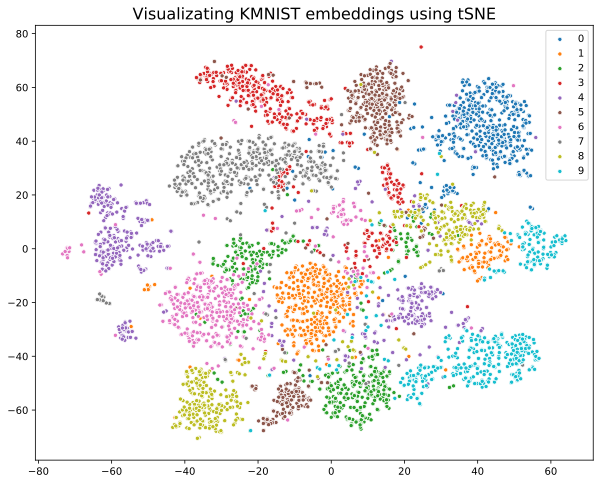

In [12]:
#Get randomly sampled data
nb_indices = 5000
random_indices, random_train_images, random_train_labels, labels = get_random_samples(nb_indices)

# Get the actual labels from the labels dictionary
labels_name = [labels_dict[x] for x in labels]

# Get a t-SNE instance
tsne = TSNE(n_components=2, random_state=seed, perplexity=30)

# Fit tsne to the data
random_train_2D = tsne.fit_transform(random_train_images)


fig = plt.figure(figsize=(10, 8))

for i, label in zip(labels, labels_name):
    sns.scatterplot(random_train_2D[random_train_labels == i, 0], 
                random_train_2D[random_train_labels == i, 1], 
                label=i, s=18)

plt.title("Visualizating KMNIST embeddings using tSNE", fontsize=16)
plt.legend()
plt.show()

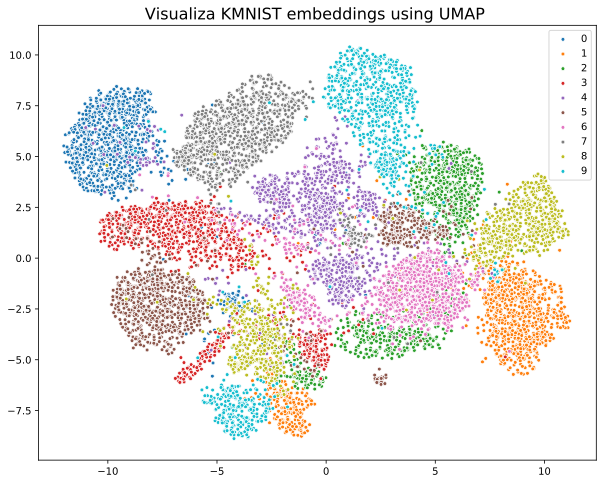

In [11]:
# Let's try UMAP now.
nb_indices = 10000
random_indices, random_train_images, random_train_labels, labels = get_random_samples(nb_indices)

embedding = umap.UMAP(n_components=2, metric='correlation', min_dist=0.8)
random_train_2D = embedding.fit_transform(random_train_images)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111) #projection='3d')

for i, label in zip(labels, labels):
    sns.scatterplot(random_train_2D[random_train_labels == i, 0], 
                random_train_2D[random_train_labels == i, 1], 
                label=label, s=15)
plt.title("Visualiza KMNIST embeddings using UMAP ", fontsize=16)
plt.legend()
plt.show()

If you look at the embeddings, you can actually see why this problem is much harder than solving simple MNIST. If you haven't seen t-SNE  and UMAP embeddings for MNIST, I will show you right here.

MNIST embeddings using t-SNE
![tsne](https://in.mathworks.com/help/examples/stats/win64/VisualizeHighDimensionalDataUsingTSNEExample_01.png)
![umap](https://raw.githubusercontent.com/lmcinnes/umap/master/images/umap_example_mnist1.png)

Both the algoritms can perfectly separate labels into different clusters but in KMNIST the clusters aren't that clear. Why do you think is the case with KMNIST? Just think about it 

### Reproducing the results provided in the paper.
In the paper, it has been mentioned that a simple CNN used in Keras examples for MNIST achieves a score of 99.06%, in terms of accuracy,  while on KMNIST, the same network is able to achieve only ~95% of accuracy, Let's validate the results. 
We will copy the [code](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) given in the keras repo for MNIST. We will train the network on KMNIST and check the final accuracy on the test set. Let's do that

In [22]:
# A bunch of variables. The variable have the same value as given in the keras example
batch_size = 64
num_classes = 10
epochs = 200

# input image dimensions
img_rows, img_cols = 28, 28

# input shape
input_shape = (img_rows, img_cols, 1)

In [18]:
# Process the train and test data in the exact same manner as done for MNIST
x_train = kmnist_train_images.astype('float32')
x_test = kmnist_test_images.astype('float32')
x_train /= 255
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

# convert class vectors to binary class matrices
y_train = to_categorical(kmnist_train_labels, num_classes)
y_test = to_categorical(kmnist_test_labels, num_classes)

In [26]:
# Build and train the model. 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s - loss: 0.7402 - acc: 0.7727 - val_loss: 0.6520 - val_acc: 0.7956
Epoch 2/200
60000/60000 [==============================] - 5s - loss: 0.3480 - acc: 0.8949 - val_loss: 0.4763 - val_acc: 0.8529
Epoch 3/200
60000/60000 [==============================] - 5s - loss: 0.2497 - acc: 0.9251 - val_loss: 0.3755 - val_acc: 0.8900
Epoch 4/200
60000/60000 [==============================] - 5s - loss: 0.2063 - acc: 0.9376 - val_loss: 0.3329 - val_acc: 0.9007
Epoch 5/200
60000/60000 [==============================] - 5s - loss: 0.1796 - acc: 0.9457 - val_loss: 0.3187 - val_acc: 0.9093
Epoch 6/200
60000/60000 [==============================] - 5s - loss: 0.1581 - acc: 0.9519 - val_loss: 0.2841 - val_acc: 0.9191
Epoch 7/200
60000/60000 [==============================] - 5s - loss: 0.1403 - acc: 0.9573 - val_loss: 0.2724 - val_acc: 0.9220
Epoch 8/200
60000/60000 [=============================

60000/60000 [==============================] - 5s - loss: 0.0133 - acc: 0.9959 - val_loss: 0.2967 - val_acc: 0.9576
Epoch 128/200
60000/60000 [==============================] - 5s - loss: 0.0110 - acc: 0.9963 - val_loss: 0.2931 - val_acc: 0.9568
Epoch 129/200
60000/60000 [==============================] - 5s - loss: 0.0115 - acc: 0.9960 - val_loss: 0.3032 - val_acc: 0.9549
Epoch 130/200
60000/60000 [==============================] - 5s - loss: 0.0105 - acc: 0.9964 - val_loss: 0.3015 - val_acc: 0.9557
Epoch 131/200
60000/60000 [==============================] - 5s - loss: 0.0105 - acc: 0.9963 - val_loss: 0.2822 - val_acc: 0.9566
Epoch 132/200
60000/60000 [==============================] - 5s - loss: 0.0102 - acc: 0.9965 - val_loss: 0.2868 - val_acc: 0.9555
Epoch 133/200
60000/60000 [==============================] - 5s - loss: 0.0112 - acc: 0.9963 - val_loss: 0.2845 - val_acc: 0.9552
Epoch 134/200
60000/60000 [==============================] - 5s - loss: 0.0101 - acc: 0.9966 - val_loss:

In [27]:
# Check the test loss and test accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Test loss: 0.2823267141334353
Test accuracy: 95.88


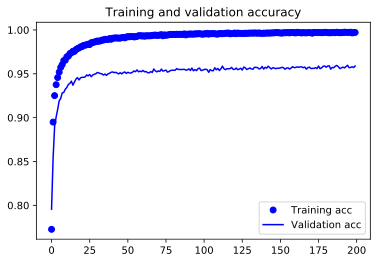

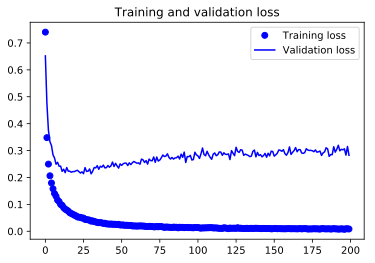

In [28]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

** Really sweet going**

As reported in the paper, the results are fully reproducible. 
1. **Accuracy**: There is however Fashion-MNIST like problem in this dataset which also chokes at $\color{red}{\text{~96%}}$ as compared to MNIST which folks (myself included) have pushed it to $\color{red}{\text{99.75%}}$ between the accuracy on MNIST and KMNIST. 
2. **Applicability**: This again proves the point that KMNIST is the perfect replacement for research and SOTA purposes as well. 
